# BARB API Demo: An audiences by time example

## The brief

In order to do some scheduling work, ITV would like to understand how their ABC1 male audience varies over a typical Monday on ITV1 in the London region.

## The API documentation

Our first step is to examine the API documentation which can be found [here](https://barb-api.co.uk/api-docs). Specificially we will be interested in the [audience_by_time](https://barb-api.co.uk/api-docs#tag/Events/operation/listAudiencesByTime) endpoint and the [panel](https://barb-api.co.uk/api-docs#tag/Metadata/operation/panelsList) and [stations](https://barb-api.co.uk/api-docs#tag/Metadata/operation/stationsList) metadata end points.

We might also look at the [Getting Started](https://barb-api.co.uk/api-docs#section/Getting-started) section for information about authentication and basic API usage.

## Set up the python environment

Next we set up our notebook with all the libraries we will need to access the API and analyse the data.

In [1]:
import requests
import numpy as np
import json
import pandas as pd
import seaborn as sns
import plotly.express as px
import plotly.io as pio
import time
pio.renderers.default = "jupyterlab"

## Get the access token

Following the steps in the Getting Started guide we run some python code to get an access token. This code uses your account details to get an access token from the API. Your creds.json file should include the email and password supplied by BARB. For example:

```
{"email": "me@coppelia.io", "password": "INSERT PASSWORD"}
```

In [2]:
with open("creds.json") as file:
    creds = json.loads(file.read())
api_root = "https://barb-api.co.uk/api/v1/"
token_request_url = api_root + "auth/token/"
response = requests.post(token_request_url, data = creds)
access_token = json.loads(response.text)['access']
headers = {'Authorization': 'Bearer {}'.format(access_token)}

## Get data from the API

### The panel code

We are only interested in the ITV London so we can use the [panels](https://barb-api.co.uk/api-docs#tag/Metadata/operation/panelsList) end point to get the right code.

In [4]:
api_url = api_root + "panels/"
response = requests.get(url = api_url,headers=headers)
panels = response.json()
[p for p in panels if "itv" in p['panel_region'].lower()]

[{'panel_code': 1,
  'panel_region': 'London - ITV,C4,ITV Breakfast',
  'is_macro_region': False},
 {'panel_code': 4,
  'panel_region': 'Midlands -ITV,C4,ITV Breakfast',
  'is_macro_region': False},
 {'panel_code': 17,
  'panel_region': 'Scotland - ITV,ITV Breakfast',
  'is_macro_region': False},
 {'panel_code': 30,
  'panel_region': 'Ulster - ITV,C4,ITV Breakfast',
  'is_macro_region': False},
 {'panel_code': 58,
  'panel_region': 'ITV Breakfast North,South,Mids',
  'is_macro_region': True},
 {'panel_code': 59,
  'panel_region': 'ITV Breakfast England & Wales',
  'is_macro_region': True},
 {'panel_code': 68,
  'panel_region': 'ITV,ITV Breakfast North Macro',
  'is_macro_region': True},
 {'panel_code': 82,
  'panel_region': 'C4 South - ITV Breakfast South',
  'is_macro_region': True},
 {'panel_code': 87,
  'panel_region': 'C4 - ITV Breakfast GB',
  'is_macro_region': True},
 {'panel_code': 99, 'panel_region': 'ITV Network', 'is_macro_region': False}]

### The station code

Next we need to use [the stations endpoint](https://barb-api.co.uk/api-docs#tag/Metadata/operation/stationsList) to get the station code for ITV 1

In [3]:
api_url = api_root + "stations/"
response = requests.get(url = api_url,headers=headers)
stations = response.json()
[s for s in stations if "itv" in s['station_name'].lower()]

[{'station_code': 30, 'station_name': 'ITV1'},
 {'station_code': 32, 'station_name': 'ITV1 HD'},
 {'station_code': 35, 'station_name': 'ITV1+1'},
 {'station_code': 4046, 'station_name': 'ITV4+1'},
 {'station_code': 4233, 'station_name': 'ITV Play'},
 {'station_code': 4269, 'station_name': 'ITV2+1'},
 {'station_code': 4270, 'station_name': 'ITV3+1'},
 {'station_code': 4328, 'station_name': 'ITV3'},
 {'station_code': 4392, 'station_name': 'ITV4'},
 {'station_code': 4393, 'station_name': 'CITV'},
 {'station_code': 4791, 'station_name': 'ITV Sport'},
 {'station_code': 4792, 'station_name': 'ITV Sport Select'},
 {'station_code': 4979, 'station_name': 'ITV2'},
 {'station_code': 5005, 'station_name': 'ITV2 HD'},
 {'station_code': 5125, 'station_name': 'ITV Encore'},
 {'station_code': 5126, 'station_name': 'ITV Encore +1'},
 {'station_code': 5148, 'station_name': 'ITVBe'},
 {'station_code': 5156, 'station_name': 'ITVBe +1'}]

### Querying the audiences by time endpoint

Now we know all the relevant metadata we can query the audiences by time endpoint. 

In [10]:
# A function to reshape the data in the way that we want it

def json_to_table(api_data):
    
    print("Downloading and processing {} audience events".format(len(api_data["events"])))
    
    # Loop through the events and then the audiences within the events
    audience_event_data = []
    for e in api_data['events']:
        for v in e['audience_views']:
            audience_event_data.append({'panel_region': e['panel']['panel_region'],
                          'station_name': e['station']['station_name'],
                          'transmission_time_period_start': e['transmission_time_period_start']['standard_datetime'],
                          'audience_code': v['audience_code'],
                          'audience_size_hundreds': v['audience_size_hundreds']})
    # Convert the result into a data frame
    audience_event_data = pd.DataFrame(audience_event_data)

    # Format the transmission_time_period as a pandas datetime
    audience_event_data['transmission_time_period_start'] = pd.to_datetime(audience_event_data['transmission_time_period_start'])
    
    ## Add the audience category names. We have a temporary problem with duplicates in this data set hence the dropping of duplicates.
    audience_categories_df = pd.DataFrame(api_data['audience_categories']).drop_duplicates(subset=['audience_code'])
    audience_event_data = audience_event_data.merge(audience_categories_df, how = "left", on = "audience_code").drop("audience_code", axis=1)
    
    return audience_event_data

Note that we are using the `x_next_url` to download the data in chunks.

In [11]:
api_url = api_root + "audiences_by_time/"

# The query parameters
params = {"min_transmission_date": "2020-01-01","max_transmission_date":"2022-12-31", 
          "station_code": 30, 
          "panel_code": 1,
          "time_period_length": 15,
          "viewing_status": "consolidated", "limit": 5000}

# Query the API and turn the response into json
start_time = time.time()
r = requests.get(url=api_url, params=params, headers=headers)
api_data = r.json()
audience_event_data = json_to_table(api_data)
while r.headers.__contains__("X-Next"):
    x_next_url = r.headers["X-Next"]
    r = requests.get(url=x_next_url, headers=headers)
    data_increment = r.json()
    audience_event_data = pd.concat([audience_event_data, json_to_table(data_increment)])
print("The download took {:.0f} seconds ".format(time.time() - start_time))

The download took 146 seconds 


This gives us the following table of data:

In [33]:
audience_event_data.tail(10)

panel_region station_name  \
131056  London - ITV,C4,ITV Breakfast         ITV1   
131057  London - ITV,C4,ITV Breakfast         ITV1   
131058  London - ITV,C4,ITV Breakfast         ITV1   
131059  London - ITV,C4,ITV Breakfast         ITV1   
131060  London - ITV,C4,ITV Breakfast         ITV1   
131061  London - ITV,C4,ITV Breakfast         ITV1   
131062  London - ITV,C4,ITV Breakfast         ITV1   
131063  London - ITV,C4,ITV Breakfast         ITV1   
131064  London - ITV,C4,ITV Breakfast         ITV1   
131065  London - ITV,C4,ITV Breakfast         ITV1   

       transmission_time_period_start  audience_size_hundreds  \
131056            2023-01-01 01:45:00                     215   
131057            2023-01-01 01:45:00                      30   
131058            2023-01-01 01:45:00                      60   
131059            2023-01-01 01:45:00                      16   
131060            2023-01-01 01:45:00                      89   
131061            2023-01-01 01:45:00                     126   
131062            2023-01-01 01:45:00                      53   
131063            2023-01-01 01:45:00                      53   
131064            2023-01-01 01:45:00                      16   
131065            2023-01-01 01:45:00                      12   

                         audience_name  audience_target_size_hundreds  
131056                     Adults ABC1                          63070  
131057                       Adults AB                          30050  
131058                        Men ABC1                          30830  
131059                          Men AB                          15320  
131060               Adults ABC1 35-54                          23850  
131061                Houseperson ABC1                          31310  
131062        Adults working full-time                          53500  
131063   Houseperson working full-time                          23180  
131064  Houseperson with children 0-15                          14500  
131065                  Children 04-09                          10270

We will add some additional date time variables to help us analyse the data.

In [62]:
men_abc_1 = audience_event_data[audience_event_data['audience_name']=="Men ABC1"]
men_abc_1 = men_abc_1.assign(day_name = men_abc_1['transmission_time_period_start'].dt.day_name())
men_abc_1 = men_abc_1.assign(transmission_time = men_abc_1['transmission_time_period_start'].dt.hour + men_abc_1['transmission_time_period_start'].dt.minute/60)
men_abc_1 = men_abc_1.assign(year = men_abc_1['transmission_time_period_start'].dt.year)

panel_region station_name  \
34      London - ITV,C4,ITV Breakfast          ITV   
265     London - ITV,C4,ITV Breakfast          ITV   
304     London - ITV,C4,ITV Breakfast          ITV   
339     London - ITV,C4,ITV Breakfast          ITV   
372     London - ITV,C4,ITV Breakfast          ITV   
...                               ...          ...   
130967  London - ITV,C4,ITV Breakfast         ITV1   
130997  London - ITV,C4,ITV Breakfast         ITV1   
131018  London - ITV,C4,ITV Breakfast         ITV1   
131038  London - ITV,C4,ITV Breakfast         ITV1   
131058  London - ITV,C4,ITV Breakfast         ITV1   

       transmission_time_period_start  audience_size_hundreds audience_name  \
34                2020-01-01 02:15:00                       9      Men ABC1   
265               2020-01-01 09:15:00                      29      Men ABC1   
304               2020-01-01 09:30:00                      56      Men ABC1   
339               2020-01-01 09:45:00                      80      Men ABC1   
372               2020-01-01 10:00:00                     119      Men ABC1   
...                               ...                     ...           ...   
130967            2023-01-01 00:45:00                     139      Men ABC1   
130997            2023-01-01 01:00:00                     121      Men ABC1   
131018            2023-01-01 01:15:00                     120      Men ABC1   
131038            2023-01-01 01:30:00                     123      Men ABC1   
131058            2023-01-01 01:45:00                      60      Men ABC1   

        audience_target_size_hundreds   day_name  transmission_time  year  
34                              29550  Wednesday               2.25  2020  
265                             29550  Wednesday               9.25  2020  
304                             29550  Wednesday               9.50  2020  
339                             29550  Wednesday               9.75  2020  
372                             29550  Wednesday              10.00  2020  
...                               ...        ...                ...   ...  
130967                          30830     Sunday               0.75  2023  
130997                          30830     Sunday               1.00  2023  
131018                          30830     Sunday               1.25  2023  
131038                          30830     Sunday               1.50  2023  
131058                          30830     Sunday               1.75  2023  

[70542 rows x 9 columns]

## Plotting the data

We overlay the 15 minute transmission period data for every Monday in the last couple of years. We fit a curve to this data to bring out the underlying pattern in the data. The audience peaks at 9:30 in the evening.

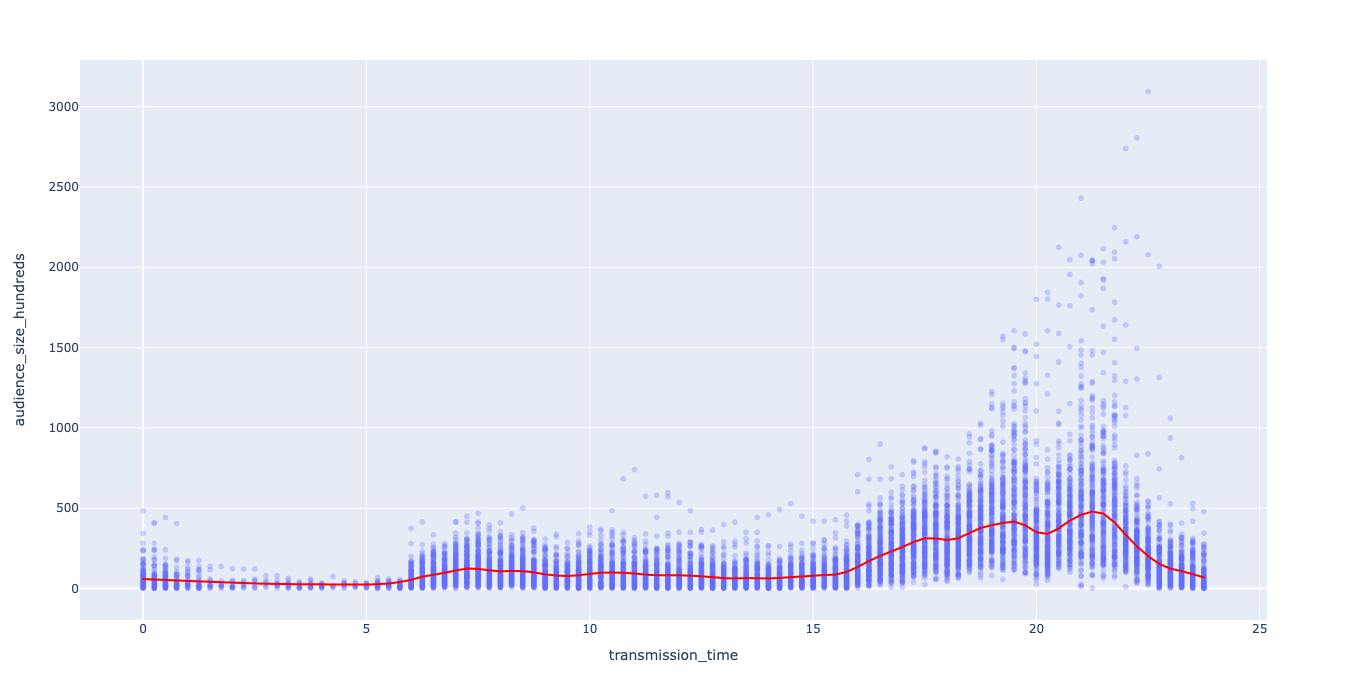

In [72]:
px.scatter(men_abc_1[men_abc_1['day_name']=='Monday'], x="transmission_time", y="audience_size_hundreds", width = 1300, 
           height=700, trendline = "lowess", opacity=0.3, trendline_options=dict(frac=0.05), trendline_color_override="red")

We can use faceting to compare Monday to the other days of the week. We have logged the y-axis to see the patterns better. The drop off on a Sunday evening is notable.

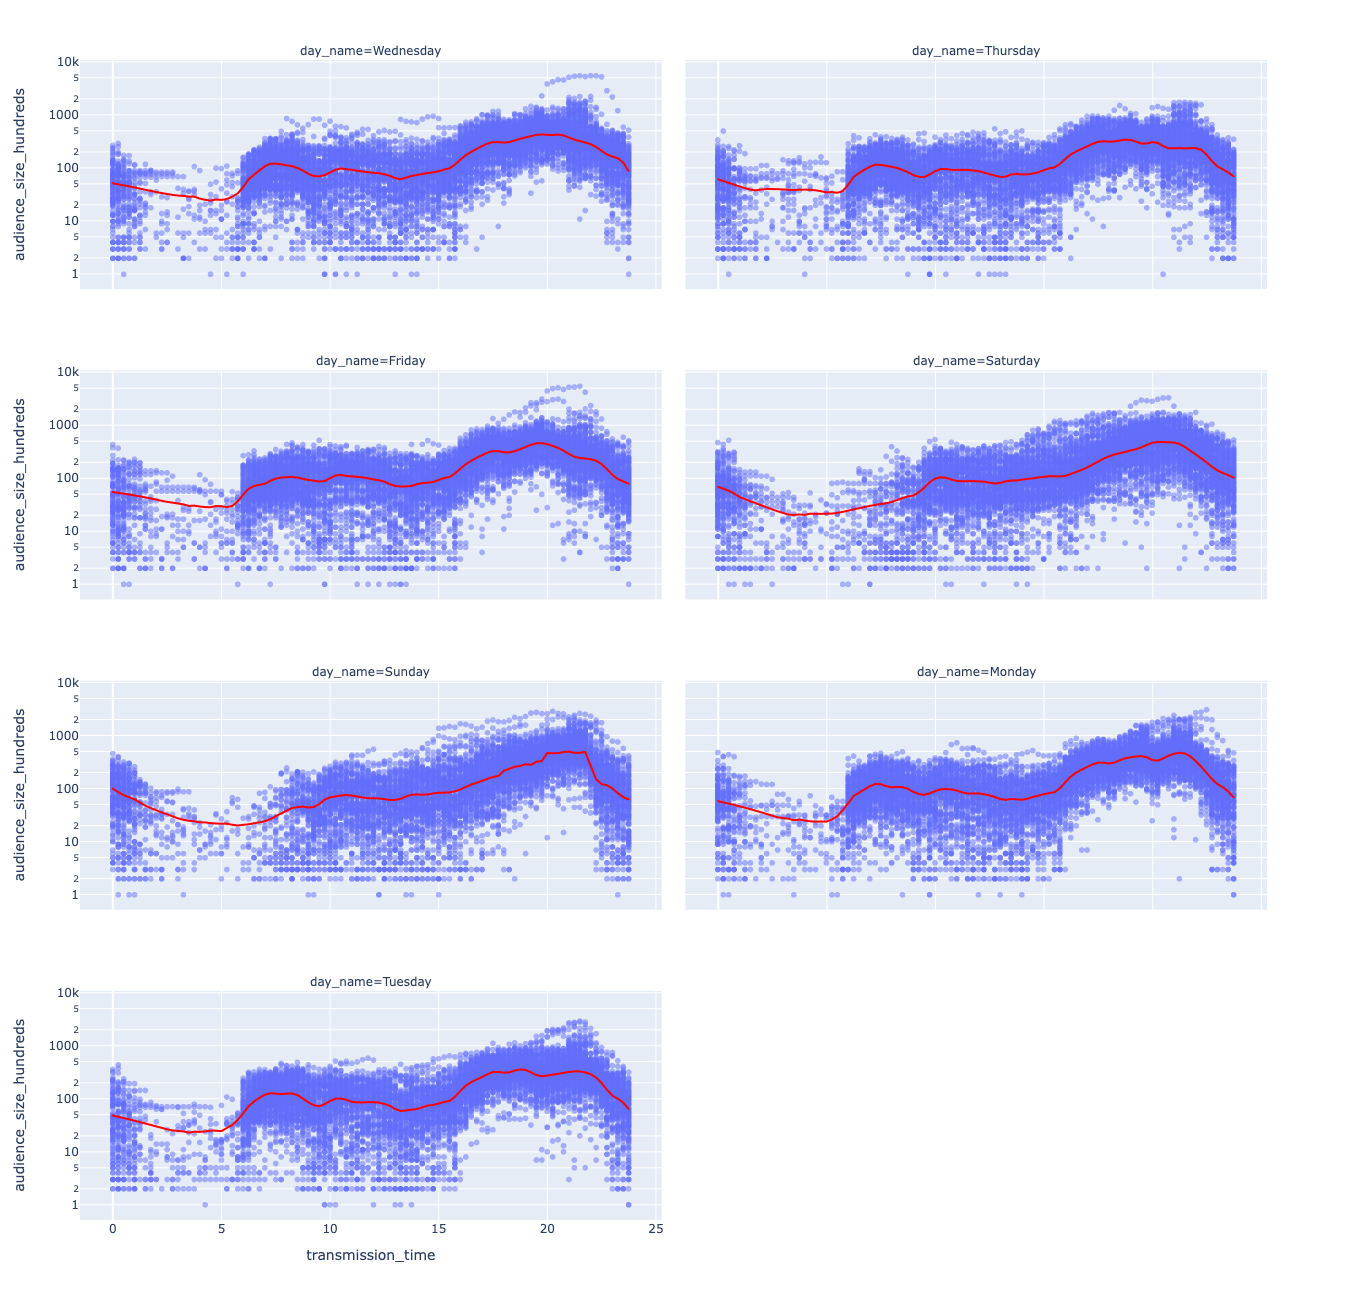

In [69]:
px.scatter(men_abc_1, x="transmission_time", y="audience_size_hundreds", width = 1300, trendline = "lowess", opacity=0.5, log_y=True,
           trendline_options=dict(frac=0.05), trendline_color_override="red", 
           facet_col = "day_name", facet_col_wrap=2, height=1300)
